# Simulation Analysis


### 1. Import Packages
Here we will be using the reading and writing tools that come with the ParFlow tools package.  

In [44]:
from set_demo_defaults import *
import xarray as xr
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

import parflow as pf
from parflow.tools.fs import get_absolute_path
from parflow.tools.io import write_pfb, read_pfb
from parflow import Run
import parflow.tools.hydrology as hydro

#setting the directory name that we will read our outputs from
run_name = 'LW_CLM'
sim_type = 'cap' #cap: capillarity, no-cap: no capillarity

#run_dir = get_absolute_path(f'outputs/{run_name}')
run_dir = get_absolute_path(f'/home/ms6985/ParFlow-project/little_washita/outputs/{run_name}')

print(run_dir)

/home/ms6985/ParFlow-project/little_washita/outputs/LW_CLM


####  2. Read in the domain properties
First we will load the run from the pfidb file and get the properties using the [data_accessor](https://parflow.readthedocs.io/en/latest/tutorials/data_accessor.html?highlight=data_accessor) and by reading out the keys we need from the model object. 


In [45]:
run = Run.from_definition(f'{run_dir}/{run_name}.pfidb')
data = run.data_accessor
nt = len(data.times)
nx = data.shape[2]
ny = data.shape[1]
nz = data.shape[0]
dx = data.dx
dy = data.dy
dz = data.dz

print(nt,nx,ny,nz,dx,dy,dz)

porosity = data.computed_porosity 
specific_storage = data.specific_storage 
mannings = run.Mannings.Geom.domain.Value
mannings = mannings*np.ones((ny, nx))
print(mannings)

## remove input filenames for TopoSlopes to force the data accessor to read the output slopes
## this fixes a windows issue
run.TopoSlopesX.FileName = None
run.TopoSlopesY.FileName = None

slopex = data.slope_x 
slopey = data.slope_y 
mask = data.mask

# formatting the mask so that values outside the domain are NA and inside the domain are 1
nanmask=mask.copy()
nanmask[nanmask == 0] = 'NaN'
nanmask[nanmask > 0] = 1

Solver: Field BinaryOutDir is not part of the expected schema <class 'parflow.tools.database.generated.Solver'>
  - nc
  - nr
  - nt
  - sw_ini
  - qflx_tran_vegm
  - scalez
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
  - sdep
  - manning
  - rout
  - cout
  - sovout
73 64 32 10 1000.0 1000.0 [1.0e+03 1.0e+02 5.0e+01 2.5e+01 1.0e+01 5.0e+00 1.0e+00 6.0e-01 3.0e-01
 1.0e-01]
[[4.4e-06 4.4e-06 4.4e-06 ... 4.4e-06 4.4e-06 4.4e-06]
 [4.4e-06 4.4e-06 4.4e-06 ... 4.4e-06 4.4e-06 4.4e-06]
 [4.4e-06 4.4e-06 4.4e-06 ... 4.4e-06 4.4e-06 4.4e-06]
 ...
 [4.4e-06 4.4e-06 4.4e-06 ... 4.4e-06 4.4e-06 4.4e-06]
 [4.4e-06 4.4e-06 4.4e-06 ... 4.4e-06 4.4e-06 4.4e-06]
 [4.4e-06 4.4e-06 4.4e-06 ... 4.4e-06 4.4e-06 4.4e-06]]


/home/SHARED/virtual-environments/parflow-shared/conda/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


#### 4. Read the simulation output files


In [46]:
#list all pressure files from outputs
lw_press_files = glob(f'{run_dir}/*out.press*.pfb')
#print(lw_press_files)
#read in all pressure files into a 3D NParray
pressure_arrays = pf.read_pfb_sequence(lw_press_files) * nanmask

#list all saturation files from outputs
lw_satur_files = glob(f'{run_dir}/*out.satur*.pfb')
#read in all pressure files into a 3D NParray
saturation_arrays = pf.read_pfb_sequence(lw_satur_files) * nanmask

#### 5. Calculate water balance
We will be using the hydrology tools to calculate the water balance. You can find more information on the tools [here](https://parflow.readthedocs.io/en/latest/tutorials/hydrology.html).

In [47]:
# Set up x and z to match the shape of the ParFlow grid
x = np.arange(0.0,(nx+1)*dx,dx)
y = np.arange(0.0,(ny+1)*dy,dy)
z = np.zeros(nz+1)
z[1:] = np.cumsum(dz)

subsurface_storage = np.zeros(nt)
surface_storage = np.zeros(nt)
wtd = np.zeros((nt, ny, nx))
et = np.zeros(nt)
overland_flow = np.zeros((nt, ny, nx))
data.time = 0

for i, (pressure, saturation) in enumerate(zip(pressure_arrays, saturation_arrays)):
    subsurface_storage[i, ...] = np.sum(hydro.calculate_subsurface_storage(porosity, pressure, saturation, specific_storage, dx, dy, dz, mask = nanmask),axis=(0, 1, 2))
    # total surface storage for this time step is the summation of substorage surface across all x/y slices
    surface_storage[i, ...] = np.sum( hydro.calculate_surface_storage(pressure, dx, dy, mask = nanmask),axis=(0, 1))
    wtd[i, ...] = hydro.calculate_water_table_depth(pressure, saturation, dz)
    
    data.time = i
    if i != 0:
        if data.et is not None:
            # total ET for this time step is the summation of ET values across all x/y/z slices
            et[i, ...] = np.sum(hydro.calculate_evapotranspiration(data.et, dx, dy, dz, mask = nanmask),axis=(0, 1, 2))

 
    overland_flow[i, ...] = hydro.calculate_overland_flow_grid(pressure, slopex, slopey, mannings, dx, dy, mask = nanmask)

### Plot Static maps of the simulation outputs

(73, 32, 64)
(73, 10, 32, 64)


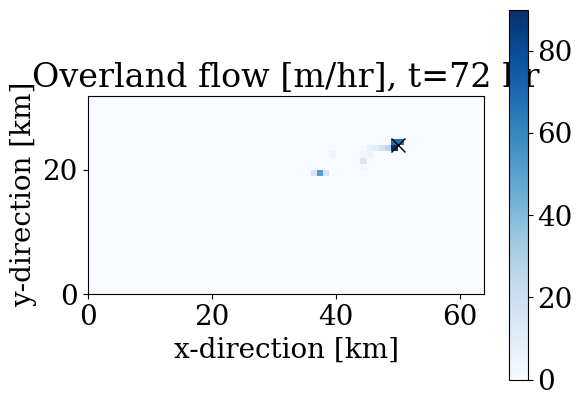

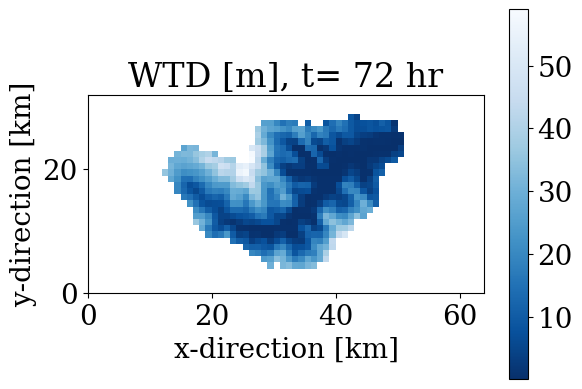

('eflx_lh_tot', 'eflx_lwrad_out', 'eflx_sh_tot', 'eflx_soil_grnd', 'qflx_evap_tot', 'qflx_evap_grnd', 'qflx_evap_soi', 'qflx_evap_veg', 'qflx_tran_veg', 'qflx_infl', 'swe_out', 't_grnd', 'qflx_qirr', 't_soil')


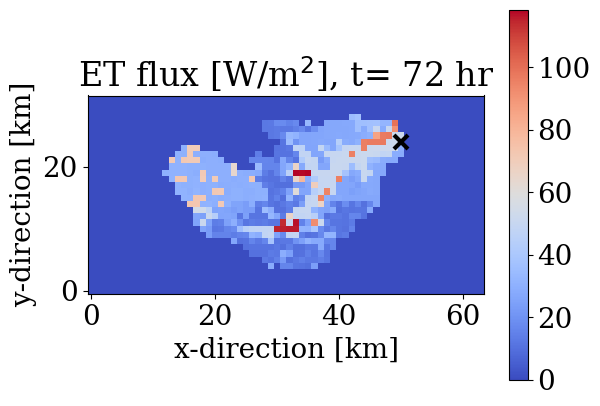

In [48]:
#CLM data array format 
# reading the CLM file PFCLM_SC.out.clm_output.<file number>.C.pfb
# variables are by layer:
# 0 eflx_lh_tot:  total latent heat flux (Wm-2)  
# 1 eflx_lwrad_out: total upward LW radiation (Wm-2)  
# 2 eflx_sh_tot: total sensible heat flux (Wm-2)  
# 3 eflx_soil_grnd: ground heat flux (Wm-2)    
# 4 qflx_evap_tot: net veg. evaporation and transpiration and soil evaporation (mms-1)  
# 5 qflx_evap_grnd: ground evaporation (mms-1)   
# 6 qflx_evap_soi: soil evaporation (mms-1)   
# 7 qflx_evap_veg: vegetation evaporation (canopy) and transpiration (mms-1)   
# 8 qflx_tran_veg: transpiration (mms-1)  
# 9 qflx_infl: infiltration flux (mms-1)   
# 10 swe_out: SWE (mm)   
# 11 t_grnd: ground temperature (K)  
# 12 irrigation flux
# 13 - 24 Soil temperature by layer (K)

print(np.shape(overland_flow))
print(np.shape(pressure_arrays))

icount = 72


fig, ax = plt.subplots(1)
ax.set_title("Overland flow [m/hr], t={} hr".format(icount))
plt.plot(x[50]/1e3,y[24]/1e3,'x',markersize=10,color='k',markeredgewidth=1)
#plt.imshow(overland_flow[icount,:,:], cmap="Blues", origin='lower')
im = ax.pcolormesh(x/1e3, y/1e3, overland_flow[icount,:,:], cmap="Blues") 
plt.colorbar(im, ax=ax)
plt.xlabel('x-direction [km]')
plt.ylabel('y-direction [km]')
ax.set_aspect('equal')
plt.savefig(f'little_washita_time{icount}hr_sim_type{sim_type}_overland.pdf',bbox_inches='tight', dpi = 600)
plt.show()

# To equalize our aspect ratio

fig, ax = plt.subplots(1)
ax.set_title("WTD [m], t= {} hr".format(icount))
#plt.imshow(wtd[icount,:,:], cmap="Blues_r", origin='lower')
im = ax.pcolormesh(x/1e3, y/1e3, wtd[icount,:,:], cmap="Blues_r") 
plt.colorbar(im, ax=ax)
plt.xlabel('x-direction [km]')
plt.ylabel('y-direction [km]')
ax.set_aspect('equal')
plt.savefig(f'little_washita_time{icount}hr_sim_type{sim_type}_WTD.pdf',bbox_inches='tight', dpi = 600)
plt.show()

#print out all CLM variables avilable
print(data.clm_output_variables)
# set time
fig, ax = plt.subplots(1)
data.time = icount
# fileter out inactive cellsfig, ax = plt.subplots(1)
ax.set_title("ET flux [W/m$^2$], t= {} hr".format(icount))
LH_plot = np.where(data.clm_output(field='eflx_lh_tot') > -99, data.clm_output(field='eflx_lh_tot'), 0.)
#im = ax.pcolormesh(x/1e3, y/1e3, LH_plot, cmap="coolwarm") 
im = plt.imshow(LH_plot, cmap="coolwarm", origin='lower')
plt.plot(x[50]/1e3,y[24]/1e3,'x',markersize=10,color='k',markeredgewidth=3)
plt.colorbar()
#plt.colorbar(im, ax=ax)
plt.xlabel('x-direction [km]')
plt.ylabel('y-direction [km]')
ax.set_aspect('equal')
plt.savefig(f'little_washita_time{icount}hr_sim_type{sim_type}_ETfluxes.pdf',bbox_inches='tight', dpi = 600)
plt.show()

### plotting components of water balance

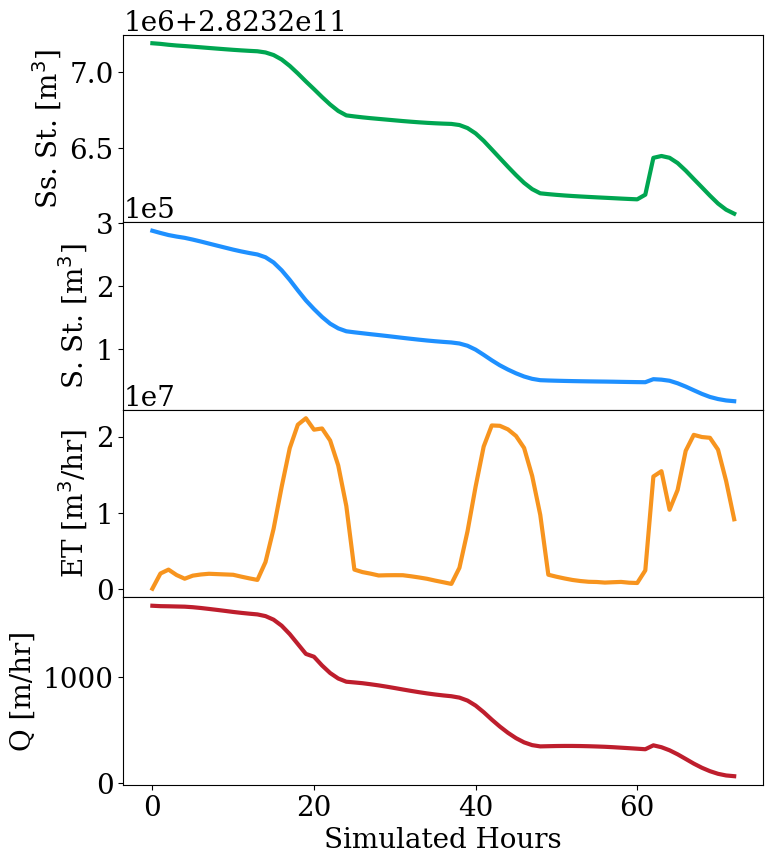

In [49]:
#plotting components of water balance
fig, axs = plt.subplots(4, sharex=True, figsize=(8,10) , dpi=100)
#fig.suptitle('Little Washita Water Balance')
axs[0].plot(subsurface_storage, linewidth=3, color = green)
axs[0].set_ylabel("Ss. St. [m$^3$]")
axs[1].plot(surface_storage, linewidth=3, color = blue)
axs[1].set_ylabel("S. St. [m$^3$]")
axs[2].plot(et, linewidth=3, color = orange)
axs[2].set_ylabel("ET [m$^3$/hr]")
axs[3].plot(overland_flow[:,24,50], linewidth=3, color = red)
axs[3].set_ylabel("Q [m/hr]")
plt.xlabel('Simulated Hours')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.85, 
                    wspace=0.0, 
                    hspace=0.0)
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.savefig(f'little_washita_time{icount}hr_sim_type{sim_type}_storage.pdf',bbox_inches='tight', dpi = 600)
np.savez(f'little_washita_time{icount}hr_sim_type{sim_type}_storage',subsurface_storage,surface_storage,et,overland_flow)  

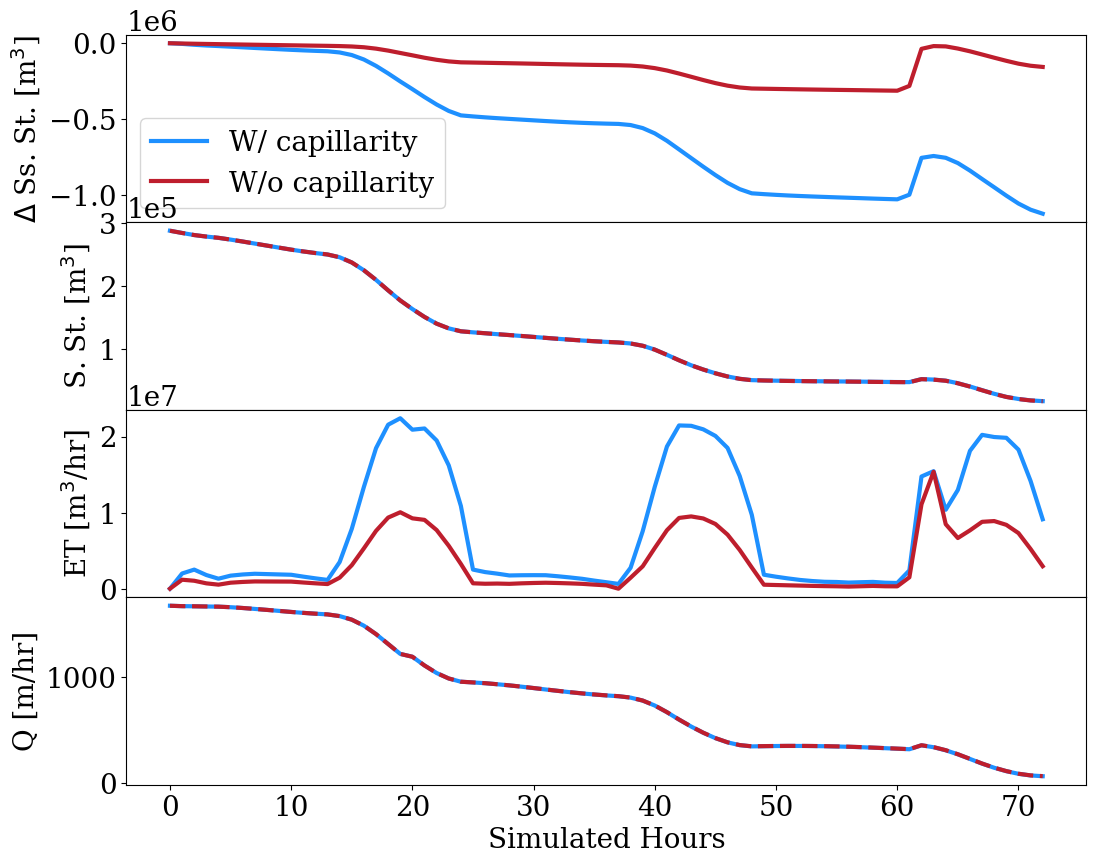

In [50]:
#Difference plots  subsurface_storage,surface_storage,et,overland_flow
no_cap = np.load(f'little_washita_time72hr_sim_typeno-cap_storage.npz'); subsurf_storage_no_cap = no_cap['arr_0']; surf_storage_no_cap = no_cap['arr_1']; et_no_cap = no_cap['arr_2']; overland_no_cap = no_cap['arr_3'];  
cap = np.load(f'little_washita_time72hr_sim_typecap_storage.npz'); subsurf_storage_cap = cap['arr_0']; surf_storage_cap = cap['arr_1']; et_cap = cap['arr_2']; overland_cap = cap['arr_3'];  

#plotting components of water balance
fig, axs = plt.subplots(4, sharex=True, figsize=(12,10) , dpi=100)
#fig.suptitle('Little Washita Water Balance')
axs[0].plot(subsurf_storage_cap-subsurf_storage_cap[0], linewidth=3, color = blue,linestyle='-',label='W/ capillarity')
axs[0].plot(subsurf_storage_no_cap-subsurf_storage_no_cap[0], linewidth=3, color = red,linestyle='-',label='W/o capillarity')
axs[0].legend(loc='best')
axs[0].set_ylabel("$\Delta$ Ss. St. [m$^3$]")
axs[1].plot(surf_storage_no_cap, linewidth=3, color = blue,linestyle='-')
axs[1].plot(surf_storage_cap, linewidth=3, color = red,linestyle='--')
axs[1].set_ylabel("S. St. [m$^3$]")
axs[2].plot(et_cap, linewidth=3, color = blue,linestyle='-')
axs[2].plot(et_no_cap, linewidth=3, color = red,linestyle='-')
axs[2].set_ylabel("ET [m$^3$/hr]")
axs[3].plot(overland_cap[:,24,50], linewidth=3, color = blue,linestyle='-')
axs[3].plot(overland_no_cap[:,24,50], linewidth=3, color = red,linestyle='--')
axs[3].set_ylabel("Q [m/hr]")
plt.xlabel('Simulated Hours')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.85, 
                    wspace=0.0, 
                    hspace=0.0)
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.savefig(f'little_washita_time{icount}hr_sim_type{sim_type}_combined.pdf',bbox_inches='tight', dpi = 600) 
